This notebook provides аn example of a simple trend-following strategy on one instrument.
The strategy is tested on synthetic continuous NQ futures on the CME.

Loading necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
%matplotlib inline

import datetime
from tqdm.notebook import tqdm
from pathlib import Path
import os

Function for reading data from a file:

In [2]:
def read_data(ticker):
    """
    Read logarithmic returns from file

    :ticker: ticker of continious futures
    """
    # You need to insert the path to the data file
    PROJECT_PATH = str(Path(os.getcwd(), 'datasets', ticker+'.csv'))
    data = pd.read_csv(PROJECT_PATH, index_col = 'date')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    # Parse timestamps
    data.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")

    return data

Functions for calculating some standard statistics:

In [3]:
days_in_year = 365.25
# Most packages use a constant of 252 trading days per year, but here we use calendar days by adding zero returns on weekends.
# This approach is used to allow for backtesting strategies that trade a portfolio of instruments on different exchanges and in different time zones.
# Trading hours on one exchange may fall on weekends on another.

def Return(rets):
    """
    Annual return estimate

    :rets: daily returns of the strategy
    """
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """
    Estimation of annual volatility

    :rets: daily returns of the strategy
    """
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """
    Estimating the annual Sharpe ratio

    :rets: daily returns of the strategy
    """
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return  pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

Reading data:

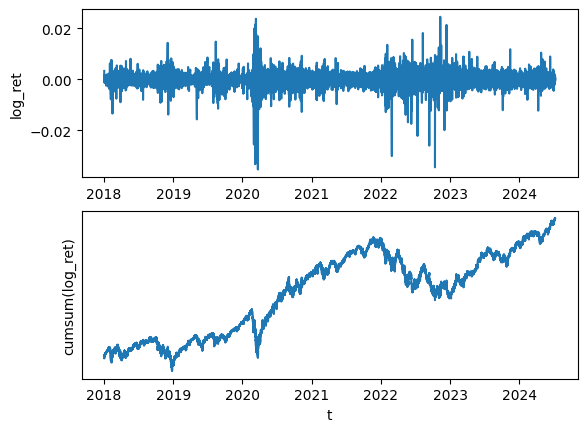

In [4]:
data = read_data('NQ')

# Let's draw graphs
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(data)
ax1.set_ylabel('log_ret')

ax2.plot(data.cumsum())
ax2.set_yticks([])
ax2.set_ylabel('cumsum(log_ret)')
_ = ax2.set_xlabel('t')

Prepare train and test samples:

In [5]:
in_sample_start = '2018-01-01'
in_sample_end = '2022-01-01'

train = data[in_sample_start:in_sample_end]
test = data[in_sample_end:]
train_test = data[in_sample_start:]

Function for strategy logic and backtest calculation:

In [6]:
def strategy_backtest(data, params, plot = False, in_sample_end = '', slippage = 0.00001):
    """
    Strategy backtest calculation
    Example call:
    strategy_bactest(test, [period, scale])

    :data: dataframe with log returns
    :params: list of strategy parameters
    :plot: if True than equity curve is plotted
    :in_sample_end: string in format "%Y-%m-%d" with timestamp of in_sample_end. Only used on charts
    :slippage: slippage per trade

    :return: statistics and equity curve
    """

    # Strategy parameters that we will optimize
    period = params[0]
    scale = params[1]

    # Calculation of target position:

    features = pd.DataFrame(index = data.index)

    # We calculate the exponential moving average of increments:
    features['signal'] = data['log_ret'].ewm(period).mean()

    # Estimating signal volatility using exponential moving average
    features['absSignal'] = np.abs(features['signal']).shift(1)
    features['signal_vol'] = features['absSignal'].ewm(200).mean()+0.000000001

    # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    # Calc target position:
    features['position'] = ((features['signal']/features['signal_vol']/features['vol']*scale).shift(1)).fillna(0).astype(int)

    # We remove looking into the future
    # (we cannot execute the order at the same price at which the signal was calculated. We need to take the price of the next bar)
    features['position'] = features['position'].shift(1)

    # We trade whole lots
    features['position'] = features['position'].fillna(0).astype(int)

    # Maximum position limit
    pos_limit = 1
    features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
    features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
         ).fillna(0).resample('1D').agg('sum')
    bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

    # We calculate statistics and save the result
    stats = statistics_calc(eq, bh, name = "{0}_{1}".format(period, scale), plot = plot)
    stats['period'] = period
    stats['scale'] = scale

    # Draw a graph of position changes, if necessary
    if plot:
        if in_sample_end  != '':
            plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')
        plt.figure()
        position_to_plot = features['position'][-10000:]
        plt.plot(np.arange(len(position_to_plot)), position_to_plot)
        plt.title('position')
        plt.xlabel('t')

    return stats, eq

Grid for strategy parameters:

In [7]:
periods = (np.logspace(1.0, 4.0, num = 20)).astype(int)
scales = np.logspace(-2.0, 0.0, num = 20).round(4)

print('Periods: ',periods)
print('Scales: ', scales)

Periods:  [   10    14    20    29    42    61    88   127   183   263   379   545
   784  1128  1623  2335  3359  4832  6951 10000]
Scales:  [0.01   0.0127 0.0162 0.0207 0.0264 0.0336 0.0428 0.0546 0.0695 0.0886
 0.1129 0.1438 0.1833 0.2336 0.2976 0.3793 0.4833 0.6158 0.7848 1.    ]


Searching through the grid of parameters (can take quite a long time):

In [8]:
stats = pd.DataFrame()

for period in tqdm(periods):
    for scale in scales:
        stats_current, _ = strategy_backtest(train, [period, scale])
        if stats.shape[0] == 0:
            stats = stats_current
        else:
            stats = pd.concat([stats, stats_current])

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization results on heatmap:

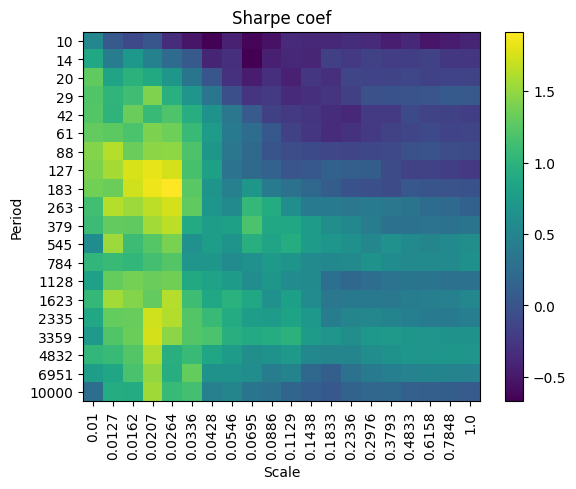

In [9]:
stats_pivot = stats.pivot(index = 'period', columns = 'scale', values = 'Sharpe ratio')

plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
plt.xticks(np.arange(len(scales)), scales, rotation = 90)
plt.yticks(np.arange(len(periods)), periods)
plt.title('Sharpe coef')
plt.xlabel('Scale')
plt.ylabel('Period')

_ = plt.colorbar()

Best set of parameters:

In [11]:
temp = stats_pivot.values
amax = temp.argmax()
row, col = (amax//temp.shape[1], amax%temp.shape[1])
print('Sharpe ratio = ', stats_pivot.iloc[row, col])
print('Period = ', stats_pivot.index[row], 'Scale = ', stats_pivot.columns[col])

best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]

Sharpe ratio =  1.9170259174787587
Period =  183 Scale =  0.0264


We calculate equity on data that includes a test period:

Sharpe ratio = 1.69
Annual Return = 0.19
Annual Std = 0.12


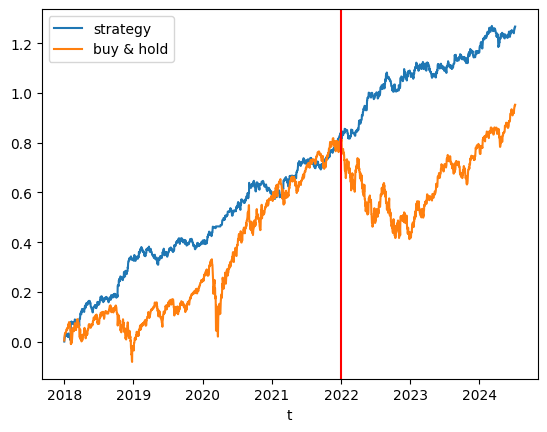

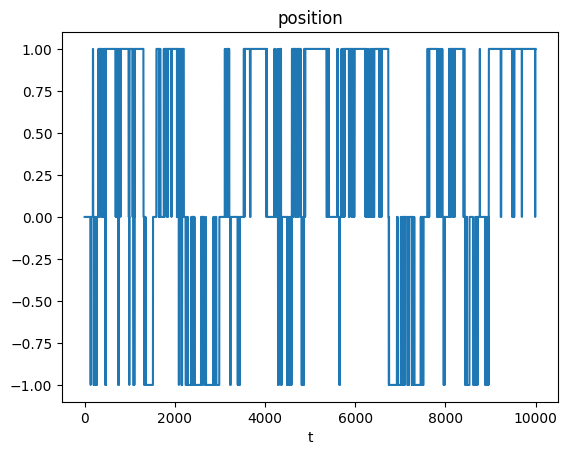

In [12]:
_, eq = strategy_backtest(train_test, [best_is_stats['period'].astype(int), best_is_stats['scale']], True, in_sample_end)

Calculate statistics on test data:

Sharpe ratio = 1.38
Annual Return = 0.17
Annual Std = 0.12


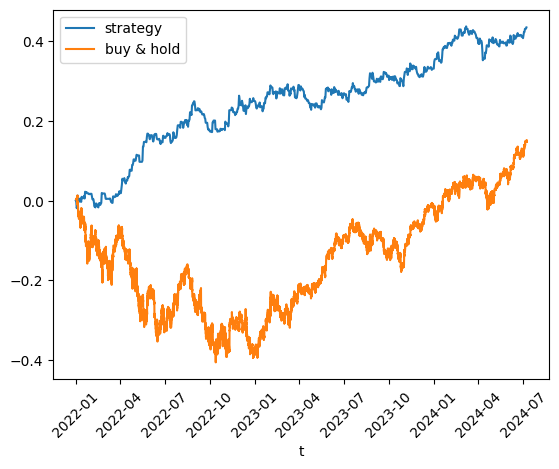

In [13]:
statistics_calc(eq[in_sample_end:], test, name = "{0}_{1}".format(period, scale), plot = True)
_=plt.xticks(rotation = 45)

Creating a report using pyfolio

In [28]:
eq_data = pd.DataFrame({
    'date': eq.index,  # Индекс (даты) становится колонкой 'date'
    'eq': eq.values    # Значения становятся колонкой 'eq'
})
eq_data

,date,eq
0,2018-01-01,0.000000
1,2018-01-02,0.007703
2,2018-01-03,0.008755
3,2018-01-04,0.000390
4,2018-01-05,0.006661
...,...,...
2376,2024-07-04,0.000203
2377,2024-07-05,0.007842
2378,2024-07-06,0.000000
2379,2024-07-07,0.000316


np.int64(0)

In [30]:
# Disabling compatibility errors
import warnings
warnings.filterwarnings('ignore')
import pyfolio as pf

np.NINF = -np.inf
pd.Series.iteritems = pd.Series.items
f = pf.create_returns_tear_sheet(eq, return_fig = True)

Start date,2018-01-01
End date,2024-07-08
Total months,113
,Backtest
Annual return,13.8%
Cumulative returns,240.3%
Annual volatility,9.6%
Sharpe ratio,1.40
Calmar ratio,1.68
Stability,0.99
Max drawdown,-8.2%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

Additional exercises and research topics:

1.  Optimize all strategy parameters. Study the sensitivity of strategy to small changes in parameters.
2.  Test the strategy on other timeframes and instruments.
3.  Try using other parametric families of functions (trend-following indicators) to form the target position.
4.  Implement a walk-forward optimization scheme.
5.  Construct a portfolio of strategies.



# Дополнительные исследования

Увеличим сетку параметров. Постараемся улучшить коефициент Шарпа

In [11]:
periods = (np.logspace(1.0, 4.0, num = 50)).astype(int)
scales = np.logspace(-2.0, 0.0, num = 50).round(4)

print('Periods: ',periods)
print('Scales: ', scales)

Periods:  [   10    11    13    15    17    20    23    26    30    35    40    47
    54    62    71    82    95   109   126   145   167   193   222   255
   294   339   390   449   517   596   686   790   910  1048  1206  1389
  1599  1842  2120  2442  2811  3237  3727  4291  4941  5689  6551  7543
  8685 10000]
Scales:  [0.01   0.011  0.0121 0.0133 0.0146 0.016  0.0176 0.0193 0.0212 0.0233
 0.0256 0.0281 0.0309 0.0339 0.0373 0.0409 0.045  0.0494 0.0543 0.0596
 0.0655 0.072  0.0791 0.0869 0.0954 0.1048 0.1151 0.1265 0.1389 0.1526
 0.1677 0.1842 0.2024 0.2223 0.2442 0.2683 0.2947 0.3237 0.3556 0.3907
 0.4292 0.4715 0.5179 0.569  0.6251 0.6866 0.7543 0.8286 0.9103 1.    ]


In [12]:
stats = pd.DataFrame()

for period in tqdm(periods):
    for scale in scales:
        stats_current, _ = strategy_backtest(train, [period, scale])
        if stats.shape[0] == 0:
            stats = stats_current
        else:
            stats = pd.concat([stats, stats_current])

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
id_max = stats['Sharpe ratio'].idxmax()
best = stats.loc[id_max]
print(f"Best params: period = {id_max.split('_')[0]}, scale = {id_max.split('_')[1]}")
print(f"Best Sharpe ratio = {best['Sharpe ratio']}")

Best params: period = 167, scale = 0.0176
Best Sharpe ratio = 2.048308909762842


Видно, что увеличением сетки параметров смогли достаточно сильно увеличить Sharpe ratio

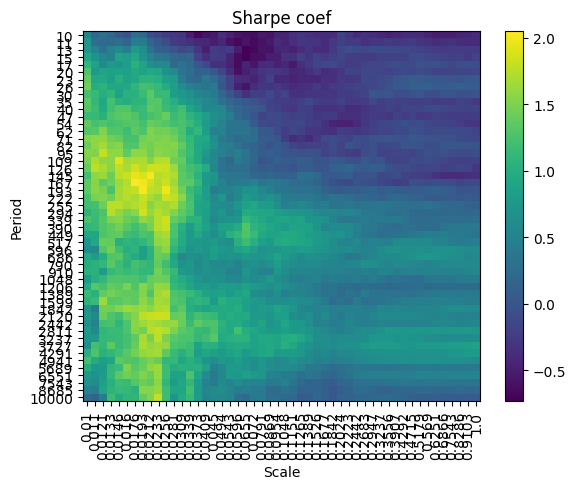

In [20]:
stats_pivot = stats.pivot(index = 'period', columns = 'scale', values = 'Sharpe ratio')

plt.imshow(stats_pivot, aspect = 'auto', interpolation = 'none')
plt.xticks(np.arange(len(scales)), scales, rotation = 90)
plt.yticks(np.arange(len(periods)), periods)
plt.title('Sharpe coef')
plt.xlabel('Scale')
plt.ylabel('Period')

_ = plt.colorbar()

In [26]:
temp = stats_pivot.values
amax = temp.argmax()
row, col = (amax//temp.shape[1], amax%temp.shape[1])
print('Sharpe ratio = ', stats_pivot.iloc[row, col])
print('Period = ', stats_pivot.index[row], 'Scale = ', stats_pivot.columns[col])

best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]

Sharpe ratio =  2.048308909762842
Period =  167 Scale =  0.0176


Sharpe ratio = 1.86
Annual Return = 0.16
Annual Std = 0.09


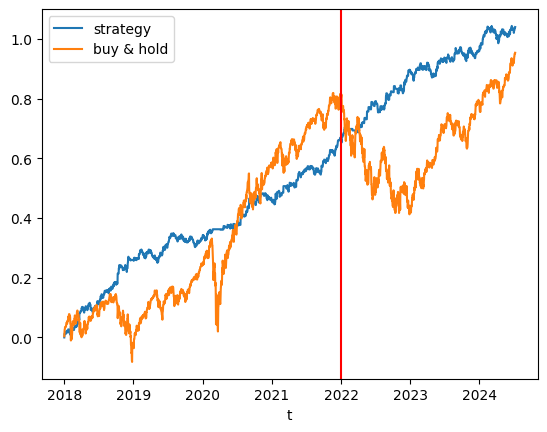

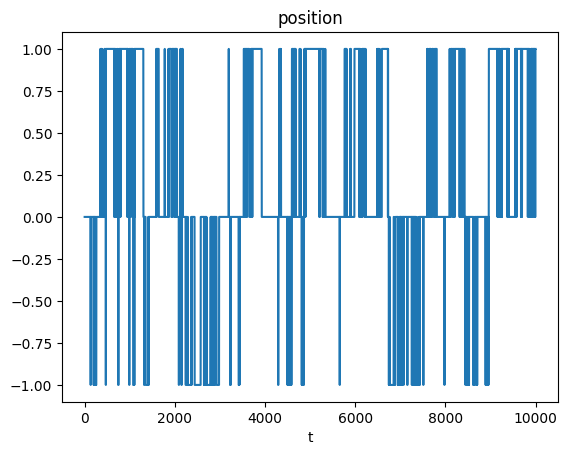

In [27]:
_, eq = strategy_backtest(train_test, [best_is_stats['period'].astype(int), best_is_stats['scale']], True, in_sample_end)

Sharpe ratio = 1.61
Annual Return = 0.15
Annual Std = 0.09


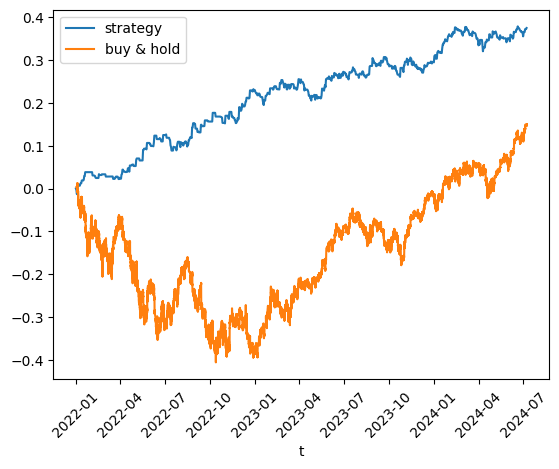

In [28]:
statistics_calc(eq[in_sample_end:], test, name = "{0}_{1}".format(period, scale), plot = True)
_=plt.xticks(rotation = 45)

В сравнении с результатами, полученными в лекции мы смогли увеличить Sharpe ratio на трейне и на тесте, но при этом немного упал Annual Return.

Также вместо банального GridSearch можно для экономии времени и увеличении сетки воспользоваться RandomSearch

In [34]:
period_min, period_max = 10, 10000
scale_min, scale_max = 0.01, 1.0

n_iter = 250

stats = pd.DataFrame()

# Randomized Search
for _ in tqdm(range(n_iter)):
    period = random.randint(period_min, period_max)
    scale = random.uniform(scale_min, scale_max)
    
    stats_current, _ = strategy_backtest(train, [period, scale])
    
    if stats.shape[0] == 0:
        stats = stats_current
    else:
        stats = pd.concat([stats, stats_current])

best_is_stats = stats.sort_values('Sharpe ratio', ascending = False).iloc[0]
print(best_is_stats)

  0%|          | 0/250 [00:00<?, ?it/s]

Sharpe ratio        1.761370
Annual return       0.171457
Volatility          0.097343
period           4471.000000
scale               0.021782
Name: 4471_0.021782157680068193, dtype: float64


Тут RandomSearch показал результаты не лучше, но зачастую когда размерность пространства гиперпараметров большое (больше 2), он может заметно лучше отрабатывать.

# Движение параметров

In [50]:
best_period = 167
best_scale = 0.0176

results_fixed_scale = []
results_fixed_period = []

period_range = np.linspace(best_period * 0.5, best_period * 1.5, 50).astype(int)
for period in period_range:
    stats_current, _ = strategy_backtest(train, [period, best_scale])
    results_fixed_scale.append({
        'period': period,
        'Sharpe ratio': stats_current['Sharpe ratio'].values[0],
        'Annual return': stats_current['Annual return'].values[0],
        'Volatility': stats_current['Volatility'].values[0]
    })

results_fixed_scale_df = pd.DataFrame(results_fixed_scale)

scale_range = np.linspace(best_scale * 0.5, best_scale * 1.5, 50)
for scale in scale_range:
    stats_current, _ = strategy_backtest(train, [best_period, scale])
    results_fixed_period.append({
        'scale': scale,
        'Sharpe ratio': stats_current['Sharpe ratio'].values[0],
        'Annual return': stats_current['Annual return'].values[0],
        'Volatility': stats_current['Volatility'].values[0]
    })

results_fixed_period_df = pd.DataFrame(results_fixed_period)

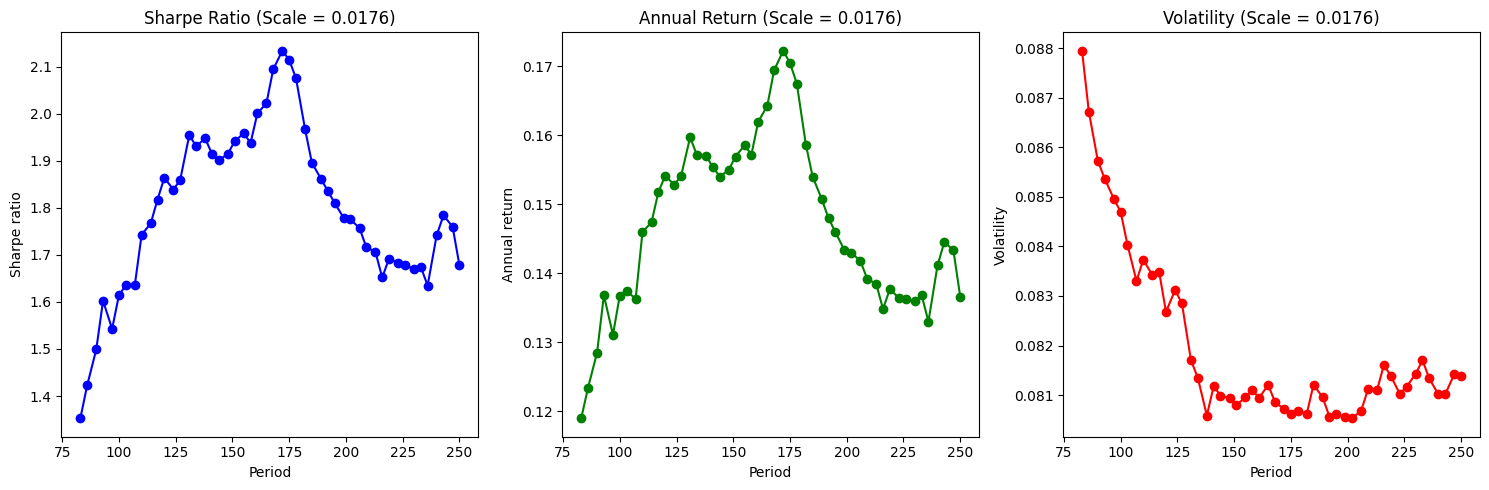

In [53]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(results_fixed_scale_df['period'], results_fixed_scale_df['Sharpe ratio'], marker='o', color='b')
plt.xlabel('Period')
plt.ylabel('Sharpe ratio')
plt.title(f'Sharpe Ratio (Scale = {best_scale})')

plt.subplot(1, 3, 2)
plt.plot(results_fixed_scale_df['period'], results_fixed_scale_df['Annual return'], marker='o', color='g')
plt.xlabel('Period')
plt.ylabel('Annual return')
plt.title(f'Annual Return (Scale = {best_scale})')

plt.subplot(1, 3, 3)
plt.plot(results_fixed_scale_df['period'], results_fixed_scale_df['Volatility'], marker='o', color='r')
plt.xlabel('Period')
plt.ylabel('Volatility')
plt.title(f'Volatility (Scale = {best_scale})')

plt.tight_layout()
plt.show()

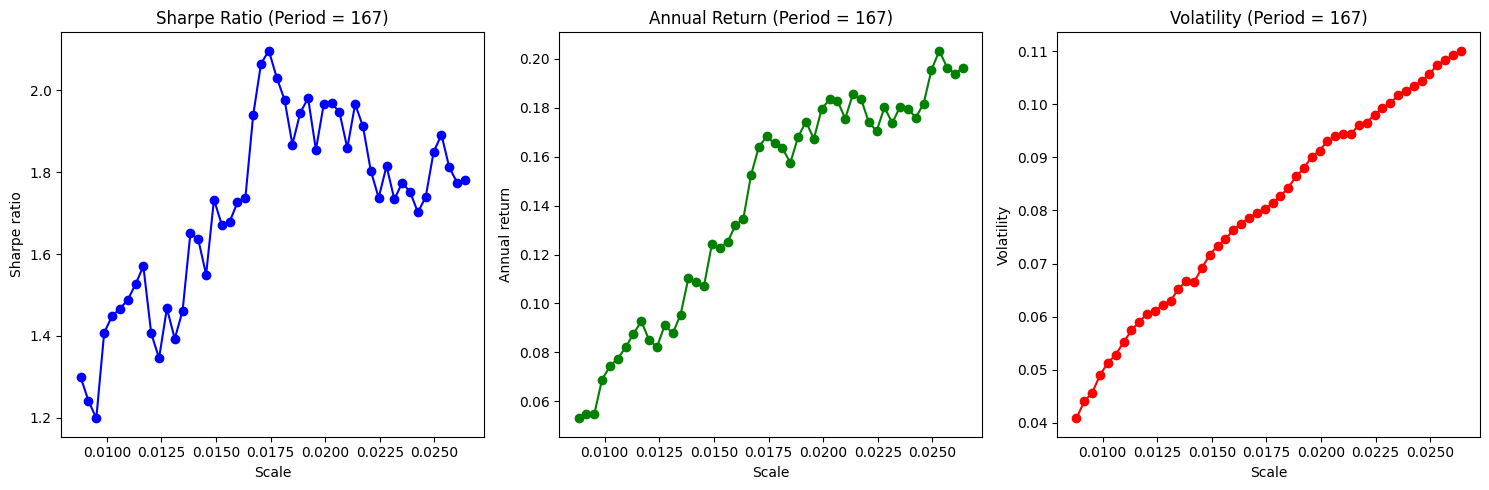

In [54]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(results_fixed_period_df['scale'], results_fixed_period_df['Sharpe ratio'], marker='o', color='b')
plt.xlabel('Scale')
plt.ylabel('Sharpe ratio')
plt.title(f'Sharpe Ratio (Period = {fixed_period})')

plt.subplot(1, 3, 2)
plt.plot(results_fixed_period_df['scale'], results_fixed_period_df['Annual return'], marker='o', color='g')
plt.xlabel('Scale')
plt.ylabel('Annual return')
plt.title(f'Annual Return (Period = {fixed_period})')

plt.subplot(1, 3, 3)
plt.plot(results_fixed_period_df['scale'], results_fixed_period_df['Volatility'], marker='o', color='r')
plt.xlabel('Scale')
plt.ylabel('Volatility')
plt.title(f'Volatility (Period = {fixed_period})')

plt.tight_layout()
plt.show()

Выводы:
1. При фиксировании Scale и увеличении периода волатильность падает, что логично. Изменение Annual Return и Sharpe Ratio довольно похожи и изменяются сильно при движении периода.
2. При фиксировании period и увеличении Scale растет волатильность, так как появляется больше рисков, связанных с увеличением кредитного плеча. Логичный результат. С ростом волатильности растет и Annual Return до некоторого значения, а дальше вероятнее всего будет идти спад.

# Тесты на других данных

Возьмем несколько активов и будем тестировать, насколько наша стратегия устойчива к другим активам и таймфреймам.

Нужно немного изменить код, используемый ранее

In [3]:
def get_annual_scaling_factor(timeframe):
    """ Возвращает корректный множитель для годовых метрик """
    minutes_per_year = 365.25 * 24 * 60  # Минут в году
    timeframe_minutes = pd.Timedelta(timeframe).total_seconds() / 60  # Минут в одном интервале
    return minutes_per_year / timeframe_minutes

def Return(rets, timeframe='1D'):
    """ Годовая доходность """
    scaling_factor = get_annual_scaling_factor(timeframe)
    return np.mean(rets) * scaling_factor

def Volatility(rets, timeframe='1D'):
    """ Годовая волатильность """
    scaling_factor = np.sqrt(get_annual_scaling_factor(timeframe))
    return np.std(rets) * scaling_factor

def SharpeRatio(rets, timeframe='1D'):
    """ Годовой коэффициент Шарпа """
    volatility = Volatility(rets, timeframe)
    if volatility > 0:
        return Return(rets, timeframe) / volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name='_', plot=False, timeframe='1D'):
    """ Рассчет статистик стратегии с учетом timeframe """
    sharpe = SharpeRatio(rets, timeframe)
    ret = Return(rets, timeframe)
    vol = Volatility(rets, timeframe)
    if plot:
        plt.plot(rets.cumsum(), label='strategy')
        plt.plot(bh.cumsum(), label='buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f' % sharpe)
        print('Annual Return = %0.2f' % ret)
        print('Annual Std = %0.2f' % vol)
    return pd.DataFrame([[sharpe, ret, vol]], columns=['Sharpe ratio', 'Annual return', 'Volatility'], index=[name])

In [4]:
def EMA(series, period):
    return series.ewm(span=period, adjust=False).mean()

def SMA(series, period):
    return series.rolling(window=period).mean()

def MACD(series, period=12):
    # оставим пока что так
    return EMA(series, 12) - EMA(series, 26)

def RSI(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    
    rs = avg_gain / (avg_loss + 1e-10)  # чтобы не делить на 0
    return 100 - (100 / (1 + rs))


In [23]:
def strategy_backtest(data, params, timeframe, indicator = "EMA", plot = False, in_sample_end = '', slippage = 0.00001):
    """
    Strategy backtest calculation
    Example call:
    strategy_bactest(test, [period, scale])

    :data: dataframe with log returns
    :params: list of strategy parameters
    :plot: if True than equity curve is plotted
    :in_sample_end: string in format "%Y-%m-%d" with timestamp of in_sample_end. Only used on charts
    :slippage: slippage per trade

    :return: statistics and equity curve
    """

    # Strategy parameters that we will optimize
    period = int(params[0])
    scale = params[1]

    indicators = {
        "EMA": lambda x: EMA(x, period),
        "SMA": lambda x: SMA(x, period),
        "MACD": lambda x: MACD(x, period),
        "RSI": lambda x: RSI(x, period)
    }
    # Calculation of target position:

    features = pd.DataFrame(index = data.index)

    # We calculate the exponential moving average of increments:
    features['signal'] = indicators[indicator](data['log_ret'])

    # Estimating signal volatility using exponential moving average
    features['absSignal'] = np.abs(features['signal']).shift(1)
    features['signal_vol'] = features['absSignal'].ewm(200).mean()+0.000000001

    # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    # Calc target position:
    features['position'] = ((features['signal']/features['signal_vol']/features['vol']*scale).shift(1)).fillna(0).astype(int)

    # We remove looking into the future
    # (we cannot execute the order at the same price at which the signal was calculated. We need to take the price of the next bar)
    features['position'] = features['position'].shift(1)

    # We trade whole lots
    features['position'] = features['position'].fillna(0).astype(int)

    # Maximum position limit
    pos_limit = 1
    features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
    features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

    # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
    eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
         ).fillna(0).resample(timeframe).agg('sum')
    bh = data['log_ret'].fillna(0).resample(timeframe).agg('sum')

    # We calculate statistics and save the result
    stats = statistics_calc(eq, bh, name = "{0}_{1}".format(period, scale), plot = plot, timeframe=timeframe)
    stats['period'] = period
    stats['scale'] = scale

    # Draw a graph of position changes, if necessary
    if plot:
        if in_sample_end  != '':
            plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')
        plt.figure()
        position_to_plot = features['position'][-10000:]
        plt.plot(np.arange(len(position_to_plot)), position_to_plot)
        plt.title('position')
        plt.xlabel('t')

    return stats, eq

NQ: min date = 2018-01-01 18:00:00, max date: 2024-07-08 11:30:00
JY: min date = 2018-01-01 18:00:00, max date: 2024-07-08 11:35:00
EU: min date = 2018-01-01 18:00:00, max date: 2024-07-08 11:35:00
GC: min date = 2018-01-01 18:00:00, max date: 2024-07-08 11:40:00
YM: min date = 2018-01-01 18:00:00, max date: 2024-07-08 11:40:00
BTC: min date = 2018-01-01 18:00:00, max date: 2024-07-08 12:35:00
ETH: min date = 2021-02-07 18:00:00, max date: 2024-07-08 11:40:00


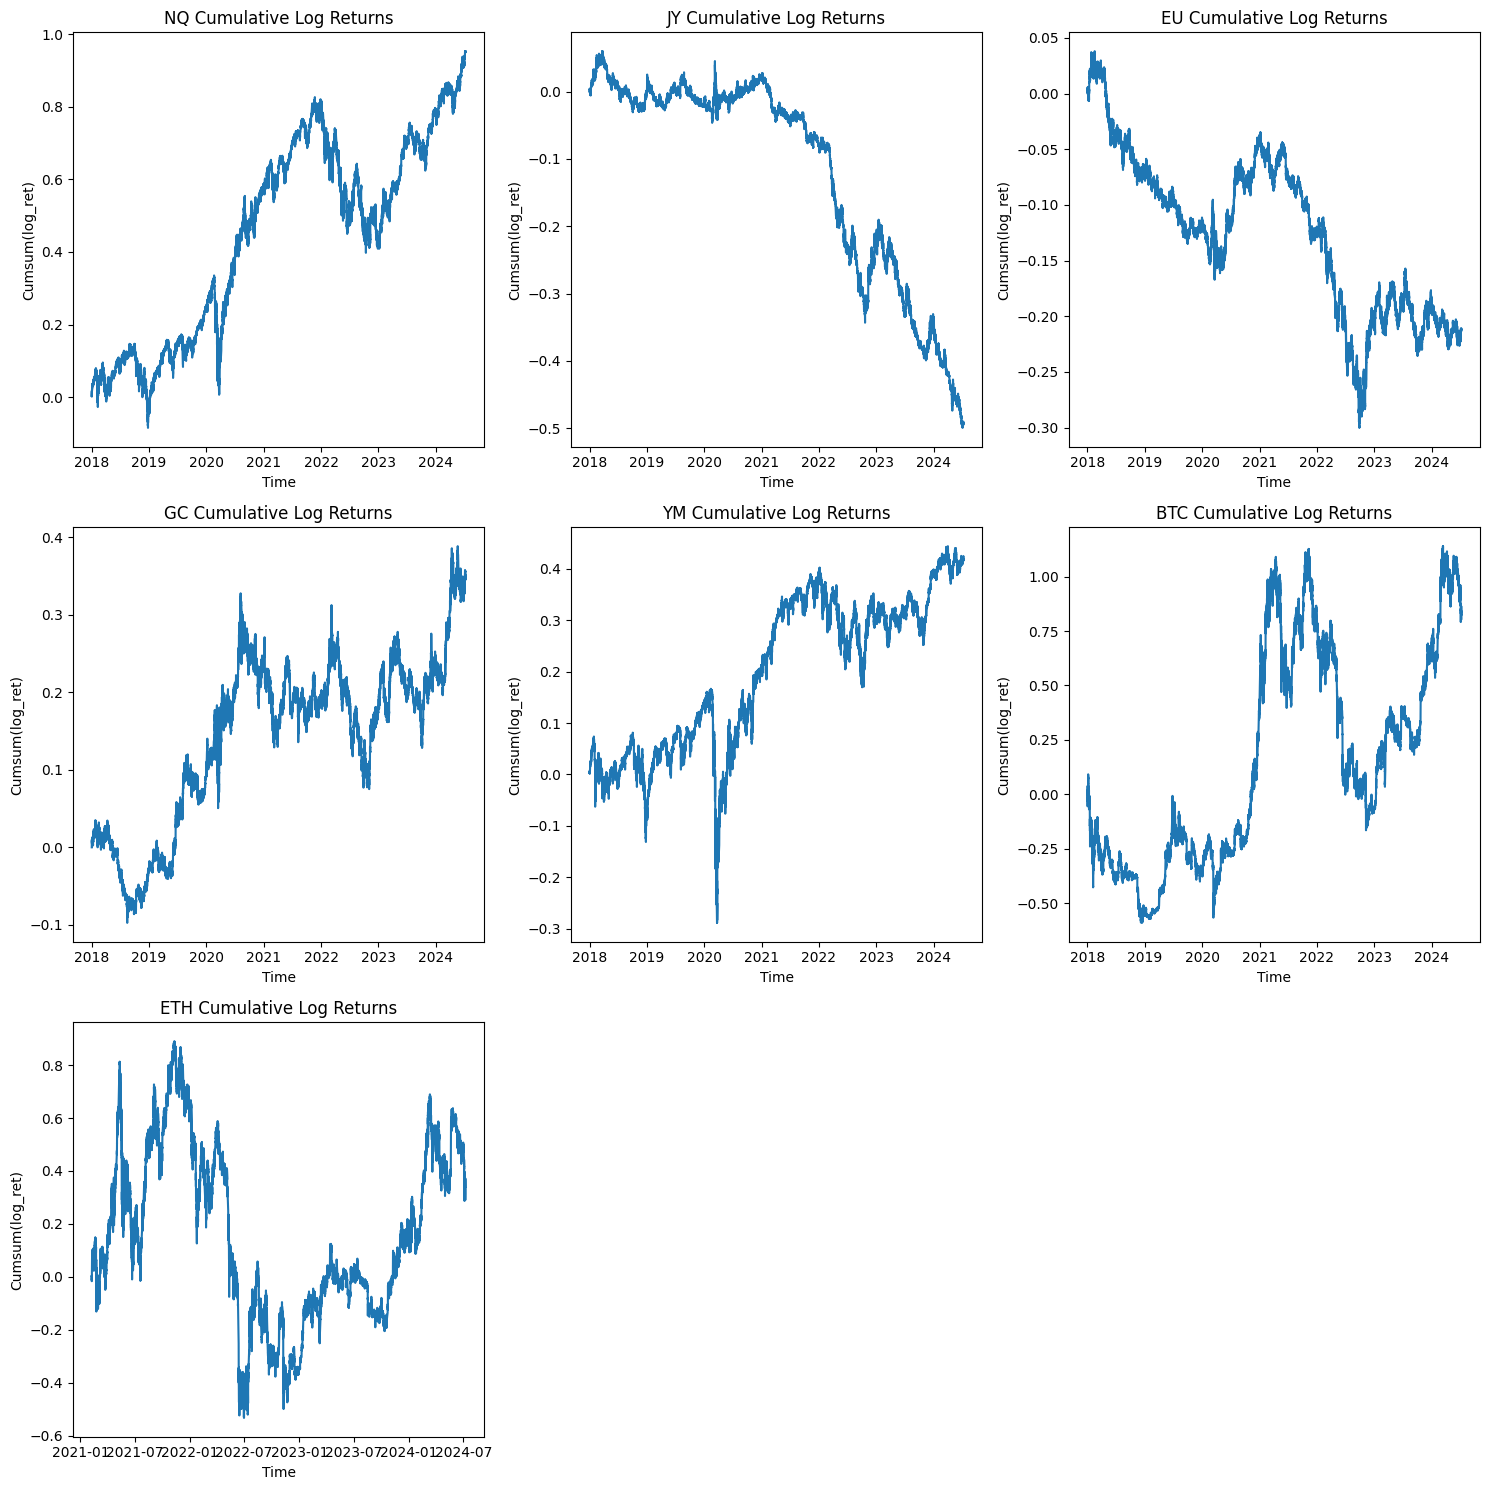

In [17]:
tickers = ['NQ', 'JY', 'EU', 'GC', 'YM', 'BTC', 'ETH']
timeframes = ['5T', '1H', '1D', '1W']

max_plots_per_row = 3
num_rows = math.ceil(len(tickers) / max_plots_per_row)

plt.figure(figsize=(5*max_plots_per_row, 5*num_rows))

for i, ticker in enumerate(tickers):
    data = read_data(ticker)
    print(f"{ticker}: min date = {data.index.min()}, max date: {data.index.max()}")
    plt.subplot(num_rows, max_plots_per_row, i + 1)
    plt.plot(data['log_ret'].cumsum(), label=ticker)
    plt.title(f'{ticker} Cumulative Log Returns')
    plt.ylabel('Cumsum(log_ret)')
    plt.xlabel('Time')
plt.tight_layout()

plt.show()

Тестовый прогон:

In [28]:
import warnings
warnings.filterwarnings('ignore')
# Результаты для каждого таймфрейма
results = []
best_period = 167
best_scale = 0.0176

for ticker in tickers:
    data = read_data(ticker)
    # in_sample_start = '2018-01-01 18:00:00'
    # in_sample_end = '2022-01-01 11:30:00'
    
    # train = data[in_sample_start:in_sample_end]
    # test = data[in_sample_end:]
    # train_test = data[in_sample_start:]
    for timeframe in timeframes:
        stats_current, _ = strategy_backtest(data, [best_period, best_scale], timeframe=timeframe, indicator="EMA")
        results.append({
            'ticker': ticker,
            'timeframe': timeframe,
            'Sharpe ratio': stats_current['Sharpe ratio'].values[0],
            'Annual return': stats_current['Annual return'].values[0],
            'Volatility': stats_current['Volatility'].values[0]
        })

# Преобразуем результаты в DataFrame
results_df = pd.DataFrame(results)
#print(results_df)

In [45]:
results_df

,ticker,timeframe,Sharpe ratio,Annual return,Volatility
0,NQ,5T,1.377164,0.127791,0.092793
1,NQ,1H,1.363975,0.127790,0.093689
2,NQ,1D,1.342745,0.127723,0.095121
3,NQ,1W,1.502461,0.127402,0.084795
4,JY,5T,-0.393616,-0.022894,0.058162
5,JY,1H,-0.398866,-0.022893,0.057396
6,JY,1D,-0.391511,-0.022881,0.058444
7,JY,1W,-0.438526,-0.022824,0.052047
8,EU,5T,-1.619897,-0.092224,0.056932
9,EU,1H,-1.649167,-0.092223,0.055921


Мы брали лучшие значения параметров конкретно для NQ и провели backtest для всех активов. Такая логика интуитивно не совсем правильная, ведь каждый актив уникален и для него нужно попробовать провести подбор параметров. Далее будет проведен более корректный подбор параметров.

# walk-forward optimization

P.S. Когда я выполнял этот пункт я не еще не знал, что walk-forward будет посвящена дальнейшая тема, поэтому вы можете не смотреть, что я тут сделал. Также я пытался создать портфель активов и соответствующих стратегий (Strategy Aggregation), как было показано в последней лекции. Но здесь это было реализовано коряво, поэтому уже более корректное исследование находиться в файле at9.ipynb.

In [6]:
def walk_forward_optimization(data, train_years=2, test_years=1, timeframe='1D', indicator='EMA'):
    """
    Оптимизация стратегии методом Walk-Forward.

    :param ticker: Название актива.
    :param train_years: Количество лет в обучающем периоде.
    :param test_years: Количество лет в тестовом периоде.
    :param timeframe: Таймфрейм ('1D', '1H' и т. д.).
    :param indicator: Индикатор ('EMA', 'SMA' и т. д.).
    :return: DataFrame с усредненными метриками по параметрам.
    """
    # data = read_data(ticker)
    periods = (np.logspace(1.0, 4.0, num=30)).astype(int)
    scales = np.logspace(-2.0, 0.0, num=30).round(4)

    min_date = data.index.min()
    max_date = data.index.max()

    train_delta = pd.DateOffset(years=train_years)
    test_delta = pd.DateOffset(years=test_years)

    results = []

    # Перебираем параметры
    for period in tqdm(periods, desc="Optimizing period"):
        for scale in scales:
            start_date = min_date
            sharpe_scores = []
            annual_returns = []
            volatilities = []
            weights = []

            # Walk-forward валидация
            while start_date + train_delta <= max_date:
                train_start = start_date
                train_end = start_date + train_delta - pd.Timedelta(minutes=1)
                test_start = train_end + pd.Timedelta(minutes=1)
                test_end = min(test_start + test_delta - pd.Timedelta(minutes=1), max_date)  # Ограничиваем конец

                train_data = data[train_start:train_end]
                test_data = data[test_start:test_end]

                if len(train_data) == 0 or len(test_data) == 0:
                    break

                stats, _ = strategy_backtest(test_data, [period, scale], timeframe, indicator)

                test_days = (test_end - test_start).days  # Считаем, сколько дней в тесте
                weight = test_days / (test_years * 365)  # Вес теста относительно полного периода

                sharpe_scores.append(stats['Sharpe ratio'].values[0] * weight)
                annual_returns.append(stats['Annual return'].values[0] * weight)
                volatilities.append(stats['Volatility'].values[0] * weight)
                weights.append(weight)

                start_date = test_start

            # Взвешенное усреднение метрик
            if weights:
                total_weight = sum(weights)
                results.append({
                    'period': period,
                    'scale': scale,
                    'Sharpe ratio': sum(sharpe_scores) / total_weight,
                    'Annual return': sum(annual_returns) / total_weight,
                    'Volatility': sum(volatilities) / total_weight
                })

    results_df = pd.DataFrame(results)

    best_params = results_df.sort_values("Sharpe ratio", ascending=False).iloc[0][["period", "scale"]].values

    print("\n===== Лучшие параметры =====")
    print(f"Period: {best_params[0]}, Scale: {best_params[1]}")
    print("\n=== Средние метрики ===")
    print(results_df.sort_values("Sharpe ratio", ascending=False).head(10))

    return results_df, best_params

In [86]:
data = read_data('NQ')

res_BTC, mean_BTC = walk_forward_optimization(data)

Optimizing period:   0%|          | 0/30 [00:00<?, ?it/s]


===== Лучшие параметры =====
Period: 356.0, Scale: 0.0137

=== Средние метрики ===
     period   scale  Sharpe ratio  Annual return  Volatility
452     356  0.0137      2.508284       0.153146    0.062355
482     452  0.0137      2.455640       0.142228    0.059618
483     452  0.0161      2.408436       0.176104    0.072772
422     280  0.0137      2.219514       0.149449    0.067262
543     727  0.0161      2.212023       0.144079    0.067092
513     573  0.0161      2.192757       0.151225    0.069472
573     923  0.0161      2.138195       0.131865    0.063511
424     280  0.0189      2.028106       0.190932    0.093313
362     174  0.0137      1.971750       0.147163    0.075501
391     221  0.0117      1.969641       0.116681    0.059512


In [71]:
res_BTC.sort_values('Sharpe ratio', ascending=False).head(5)

,period,scale,Sharpe ratio,Annual return,Volatility
162,183,0.0162,2.477888,0.198359,0.078370
81,42,0.0127,2.428454,0.189116,0.077896
121,88,0.0127,2.290591,0.168874,0.071793
61,29,0.0127,2.238618,0.196438,0.087021
163,183,0.0207,2.202887,0.240729,0.104677


В рамках нашей текущей задачи мы максимизируем sharpe ratio, но при этом annual return может быть не самый лучший. В идеале нужно находить баланс, но сейчас я сделаю общий прогон по всем активам, найду лучшие параметры, подберу лучший индикатор для каждого актива и получу оптимальную стратегию для каждого актива с максимизацией именно sharpe ratio.

In [101]:
data = read_data('NQ')
f = strategy_backtest(data, best_params_all['NQ'], '1D')
f

(              Sharpe ratio  Annual return  Volatility  period   scale
 356.0_0.0137      1.438892          0.097    0.067413   356.0  0.0137,
 date
 2018-01-01    0.000000
 2018-01-02    0.000000
 2018-01-03    0.000000
 2018-01-04    0.000000
 2018-01-05    0.000000
                 ...   
 2024-07-04    0.000000
 2024-07-05    0.002861
 2024-07-06    0.000000
 2024-07-07    0.000136
 2024-07-08   -0.000244
 Freq: D, Length: 2381, dtype: float64)

In [106]:
f[0]['Annual return'].values[0]

np.float64(0.09699984899166594)

In [9]:
best_params_all = dict()
for ticker in tqdm(tickers):
    data = read_data(ticker)
    split_index = int(len(data) * 0.8)  # 80% обучающие, 20% тестовые
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]
    
    data_, best_params = walk_forward_optimization(train_data, train_years=2, test_years=1)
    final_stats = strategy_backtest(test_data, best_params, '1D')
    best_params_all[ticker] = [list(best_params), final_stats[0]['Sharpe ratio'].values[0],final_stats[0]['Annual return'].values[0]]
    

  0%|          | 0/7 [00:00<?, ?it/s]

Optimizing period:   0%|          | 0/30 [00:00<?, ?it/s]


===== Лучшие параметры =====
Period: 356.0, Scale: 0.0137

=== Средние метрики ===
     period   scale  Sharpe ratio  Annual return  Volatility
452     356  0.0137      2.869609       0.172339    0.060100
482     452  0.0137      2.719449       0.150744    0.055335
483     452  0.0161      2.540039       0.182410    0.070934
543     727  0.0161      2.531987       0.160649    0.063200
573     923  0.0161      2.391781       0.140678    0.058076
663    1887  0.0161      2.374655       0.131700    0.055429
542     727  0.0137      2.360778       0.108706    0.046092
424     280  0.0189      2.318419       0.217871    0.092664
513     573  0.0161      2.283913       0.150856    0.065983
422     280  0.0137      2.261562       0.148715    0.065510


Optimizing period:   0%|          | 0/30 [00:00<?, ?it/s]


===== Лучшие параметры =====
Period: 3039.0, Scale: 0.01

=== Средние метрики ===
     period   scale  Sharpe ratio  Annual return  Volatility
720    3039  0.0100      1.358736       0.060691    0.039590
690    2395  0.0100      1.322384       0.063712    0.041523
540     727  0.0100      1.240208       0.071947    0.045124
572     923  0.0137      1.218240       0.078290    0.055125
486     452  0.0259      1.212136       0.089695    0.069737
603    1172  0.0161      1.177686       0.091872    0.060472
692    2395  0.0137      1.169040       0.090965    0.054614
481     452  0.0117      1.147921       0.069829    0.050269
573     923  0.0161      1.139809       0.083282    0.059694
602    1172  0.0137      1.117943       0.081079    0.055806


Optimizing period:   0%|          | 0/30 [00:00<?, ?it/s]


===== Лучшие параметры =====
Period: 3039.0, Scale: 0.0117

=== Средние метрики ===
     period   scale  Sharpe ratio  Annual return  Volatility
721    3039  0.0117      0.426178       0.020534    0.043880
691    2395  0.0117      0.219600       0.010460    0.043462
662    1887  0.0137      0.153139       0.002589    0.051719
826    6210  0.1269      0.109146       0.012154    0.080849
782    4893  0.0137      0.068467       0.003249    0.051621
833    6210  0.3857      0.067450       0.007496    0.080904
834    6210  0.4520      0.067028       0.007631    0.080865
572     923  0.0137      0.061946      -0.000654    0.050846
812    6210  0.0137      0.060855       0.002304    0.050816
835    6210  0.5298      0.054500       0.006718    0.081109


Optimizing period:   0%|          | 0/30 [00:00<?, ?it/s]


===== Лучшие параметры =====
Period: 10000.0, Scale: 0.0161

=== Средние метрики ===
     period   scale  Sharpe ratio  Annual return  Volatility
873   10000  0.0161      1.919073       0.098787    0.051212
874   10000  0.0189      1.532182       0.112202    0.072805
844    7880  0.0189      1.374533       0.102043    0.073499
843    7880  0.0161      1.356824       0.073403    0.053813
514     573  0.0189      1.257010       0.112092    0.086308
875   10000  0.0221      1.228402       0.111857    0.091147
548     727  0.0356      1.203548       0.168122    0.129503
545     727  0.0221      1.151838       0.119175    0.098885
845    7880  0.0221      1.117584       0.104223    0.091796
483     452  0.0161      1.117242       0.090866    0.078322


Optimizing period:   0%|          | 0/30 [00:00<?, ?it/s]


===== Лучшие параметры =====
Period: 174.0, Scale: 0.0221

=== Средние метрики ===
     period   scale  Sharpe ratio  Annual return  Volatility
365     174  0.0221      1.334712       0.118263    0.096786
335     137  0.0221      1.294408       0.106950    0.097745
395     221  0.0221      1.276977       0.107141    0.095480
425     280  0.0221      1.253865       0.114891    0.094862
662    1887  0.0137      1.196203       0.054253    0.043859
304     108  0.0189      1.183966       0.099610    0.090034
575     923  0.0221      1.146118       0.103703    0.092441
692    2395  0.0137      1.136939       0.053814    0.043612
605    1172  0.0221      1.136541       0.098173    0.087889
634    1487  0.0189      1.127568       0.080256    0.073275


Optimizing period:   0%|          | 0/30 [00:00<?, ?it/s]


===== Лучшие параметры =====
Period: 52.0, Scale: 0.0221

=== Средние метрики ===
     period   scale  Sharpe ratio  Annual return  Volatility
215      52  0.0221      2.973382       0.405998    0.136296
214      52  0.0189      2.898840       0.343793    0.119025
154      32  0.0189      2.837828       0.362443    0.128227
245      67  0.0221      2.816801       0.364209    0.130046
184      41  0.0189      2.784980       0.341273    0.122284
153      32  0.0161      2.677286       0.299658    0.112994
242      67  0.0137      2.665060       0.227216    0.085429
185      41  0.0221      2.664589       0.380729    0.141533
363     174  0.0161      2.610290       0.219689    0.085034
457     356  0.0304      2.576422       0.413340    0.161692


Optimizing period:   0%|          | 0/30 [00:00<?, ?it/s]


===== Лучшие параметры =====
Period: 2395.0, Scale: 0.0259

=== Средние метрики ===
     period   scale  Sharpe ratio  Annual return  Volatility
696    2395  0.0259      2.814841       0.297932    0.105843
577     923  0.0304      2.718986       0.433781    0.159538
576     923  0.0259      2.632660       0.344721    0.130940
94       20  0.0189      2.627940       0.363226    0.138217
64       16  0.0189      2.602970       0.355724    0.136661
546     727  0.0259      2.555439       0.347006    0.135791
607    1172  0.0304      2.472570       0.399754    0.161675
516     573  0.0259      2.441858       0.331059    0.135577
93       20  0.0161      2.413128       0.313593    0.129953
726    3039  0.0259      2.410266       0.248163    0.102961


In [10]:
best_params_all

{'NQ': [[np.float64(356.0), np.float64(0.0137)],
  np.float64(0.8405765584620278),
  np.float64(0.06272661302151242)],
 'JY': [[np.float64(3039.0), np.float64(0.01)],
  np.float64(1.2063244404790312),
  np.float64(0.057919204064608834)],
 'EU': [[np.float64(3039.0), np.float64(0.0117)],
  np.float64(-1.1663434799492263),
  np.float64(-0.060527584833117376)],
 'GC': [[np.float64(10000.0), np.float64(0.0161)],
  np.float64(0.860421404152373),
  np.float64(0.04907643965925973)],
 'YM': [[np.float64(174.0), np.float64(0.0221)],
  np.float64(-1.723606136443515),
  np.float64(-0.14123387468276288)],
 'BTC': [[np.float64(52.0), np.float64(0.0221)],
  np.float64(1.3581933130048827),
  np.float64(0.20124540030730048)],
 'ETH': [[np.float64(2395.0), np.float64(0.0259)],
  np.float64(1.4331687300548734),
  np.float64(0.17293778127444412)]}

Теперь подберем индикатор

In [11]:
class Strategy():
    def __init__(self, params, indicator, timeframe):
        self.params = params
        self.indicator = indicator
        self.timeframe = timeframe
        self.sharpe = None
        self.annual_return = None
        self.vol = None
        
    def backtest(self, data, plot = False, in_sample_end = '', slippage = 0.00001):
        """
        Strategy backtest calculation
        Example call:
        strategy_bactest(test, [period, scale])
    
        :data: dataframe with log returns
        :params: list of strategy parameters
        :plot: if True than equity curve is plotted
        :in_sample_end: string in format "%Y-%m-%d" with timestamp of in_sample_end. Only used on charts
        :slippage: slippage per trade
    
        :return: statistics and equity curve
        """
    
        # Strategy parameters that we will optimize
        period = self.params[0]
        scale = self.params[1]
    
        indicators = {
            "EMA": lambda x: EMA(x, period),
            "SMA": lambda x: SMA(x, period),
            "MACD": lambda x: MACD(x, period),
            "RSI": lambda x: RSI(x, period)
        }
        # Calculation of target position:
    
        features = pd.DataFrame(index = data.index)
    
        # We calculate the exponential moving average of increments:
        features['signal'] = indicators[self.indicator](data['log_ret'])
    
        # Estimating signal volatility using exponential moving average
        features['absSignal'] = np.abs(features['signal']).shift(1)
        features['signal_vol'] = features['absSignal'].ewm(200).mean()+0.000000001
    
        # Estimating asset volatility using double exponential moving average:
        features['absRet'] = np.abs(data['log_ret'])
        features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
        features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001
    
        # Calc target position:
        features['position'] = ((features['signal']/features['signal_vol']/features['vol']*scale).shift(1)).fillna(0).astype(int)
    
        # We remove looking into the future
        # (we cannot execute the order at the same price at which the signal was calculated. We need to take the price of the next bar)
        features['position'] = features['position'].shift(1)
    
        # We trade whole lots
        features['position'] = features['position'].fillna(0).astype(int)
    
        # Maximum position limit
        pos_limit = 1
        features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
        features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit
    
        # We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
        eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
             ).fillna(0).resample(timeframe).agg('sum')
        bh = data['log_ret'].fillna(0).resample(timeframe).agg('sum')
    
        # We calculate statistics and save the result
        stats = statistics_calc(eq, bh, name = "{0}_{1}".format(period, scale), plot = plot, timeframe=timeframe)
        stats['period'] = period
        stats['scale'] = scale
    
        # Draw a graph of position changes, if necessary
        if plot:
            if in_sample_end  != '':
                plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')
            plt.figure()
            position_to_plot = features['position'][-10000:]
            plt.plot(np.arange(len(position_to_plot)), position_to_plot)
            plt.title('position')
            plt.xlabel('t')

        self.sharpe = stats['Sharpe ratio']
        self.annual_return = stats['Annual return']
        self.vol = stats['Volatility']
        return stats, eq

    def get_stats(self):
        if self.sharpe:
            return pd.DataFrame(data=[[self.timeframe, self.params[0], self.params[1], self.sharpe, self.annual_return, self.vol]],
                               columns=['Timeframe', 'Period', 'Scale', 'Sharpe ratio', 'Annual return', 'Volatility'],
                               index=ticker)
        return None

In [30]:
tickers = ['NQ', 'JY', 'EU', 'GC', 'YM', 'BTC', 'ETH']
timeframes = ['5T', '1H', '1D', '1W']
indicators_ = ['EMA', 'SMA', 'MACD', 'RSI']
indicators_tickers = dict()

strategies = dict()
for ticker in tqdm(tickers):
    data = read_data(ticker)
    split_index = int(len(data) * 0.8)  # 80% обучающие, 20% тестовые
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]
    best_score = 0
    cur_score = 0
    best_ind = 'EMA'
    print(ticker, best_params_all[ticker][0])
    for indicator in indicators_:
        res, _ = strategy_backtest(train_data, best_params_all[ticker][0], '1D', indicator)
        cur_score = res['Sharpe ratio'].values[0]
        if cur_score > best_score:
            best_score = cur_score
            best_ind = indicator
            
    best_score = 0
    cur_score = 0
    best_timeframe = '1D'
    for timeframe in timeframes:
        res, _ = strategy_backtest(train_data, best_params_all[ticker][0], timeframe, best_ind)
        cur_score = res['Sharpe ratio'].values[0]
        if cur_score > best_score:
            best_score = cur_score
            best_timeframe = timeframe
    strategy = Strategy(best_params_all[ticker][0], best_ind, best_timeframe)
    strategies[ticker] = strategy
    strategies[ticker].backtest(test_data)
    

  0%|          | 0/7 [00:00<?, ?it/s]

NQ [np.float64(356.0), np.float64(0.0137)]
JY [np.float64(3039.0), np.float64(0.01)]
EU [np.float64(3039.0), np.float64(0.0117)]
GC [np.float64(10000.0), np.float64(0.0161)]


ValueError: window must be an integer 0 or greater